# Лабораторная работа 1. Нейронные сети.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за всю работу — 15 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_01.ipynb.

# Часть 3. Рекуррентные языковые модели

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSj85jp-W-V-Bz8ZBjFJYIkV1TTxQxTMh4iqls_rRt8O-sraL08PA)

В этой части домашней работы мы создадим языковую модель на рекуррентных нейросетях (RNN) и заставим её придумывать имена.

__Языковая модель__, если вкратце, это модель, которая умеет как предсказывать вероятность некоторого текста. Ее можно использовать также чтобы генерировать текст в соответствии с обученными вероятностями. Задание будет заключаться в том, чтобы научить модель генерировать новые имена, скормив ей для этого 8к существующих.

В данном случае в качестве входных данных мы будет работать со строками, которые можно рассматривать как последовательности _символов_: $\{x_0, x_1, x_2, ..., x_n\}$. 

Наша основная задача — научиться предсказывать вероятность следующего символа:
$$ p(x_0, x_1, x_2, ..., x_n) = \prod_t p(x_t | x_0, ... x_{t - 1}) $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Данные

Мы будем строить языковую модель по ~8k человеческих имён на латинице. Если когда-нибудь вам нужно будет дать имя своему ребёнку, у вас будет для этого генеративная нейросетевая модель.

Давайте их прочитаем:
* Считайте все строки из файла `./names` в список
* В начало каждой строки допишите __пробел__
* В конце сроки не должно быть переноса (`\n`)

In [2]:
import os
start_token = " "

with open('./names', 'r') as file:
    names = file.readlines()

#add space and remove \n
for i, name in enumerate(names):
    names[i] = start_token + name[:-1]

In [3]:
assert all(line[0] == start_token for line in names)
assert all(line[-1] != '\n' for line in names)

In [4]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


Проверьте, что все корректно:

In [5]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)
assert MAX_LENGTH == 16 , "max length (for names) should be 16. remove assert if you work on different dataset"

max length = 16


## Словари

В начале нам будет необходимо построить "словарь" — упорядоченное множество уникальных символов, которые сеть может породить. Это нужно, чтобы уметь сопоставить каждому символу свой номер. Перед отправкой в сеть все символы будут кодироваться их номерами в словаре.

Также необходимо добавить в словарь пробельный символ, который будет использоваться в качестве специального токена.

In [6]:
tokens = np.unique(list(''.join(names)))

tokens = sorted(list(tokens))

n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

assert 50 < n_tokens < 60

n_tokens =  55


А теперь построим обратный словарь: для каждой буквы посчитаем её номер в списке токенов.

In [7]:
token_to_id = dict(zip(tokens, np.arange(n_tokens)))

И проверим, все ли корректно:

In [8]:
assert len(tokens) == len(token_to_id), "число токенов должно совпадать"

for i in range(n_tokens):
    if token_to_id[tokens[i]] != i:
        print(i)
    assert token_to_id[tokens[i]] == i, "словарь должен указывать на индекс буквы в tokens"

print("Кажется заработало...")

Кажется заработало...


Имея построенное соответствие, можно преобразовать батч входных данных в матрицу int32 номеров токенов. Так как в батче все строки должны быть одной длины, слишком короткие строки в батче нужно будет дополнить пробелами (паддинг).

In [9]:
lines = names
def to_matrix(lines, max_len=None, pad=token_to_id[' '], dtype='int32'):
    """Casts a list of names into rnn-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i]))
        lines_ix[i, :len(line_ix)] = line_ix

    return lines_ix

In [10]:
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[ 0  3 30 29 35 29 33 40  0]
 [ 0  9 40 43 46 53  0  0  0]
 [ 0 18 46 37 47 47 37 33  0]
 [ 0  9 37 43 50 29 42 42 33]]


## Один шаг RNN

Рекуррентная нейронная сеть (RNN) — это такая сеть с <s>блокнотом</s> состоянием $h$, в который она умеет писать то, что видела.

Сеть начинает с пустого $h_0 = \vec 0$, после чего текст обрабатывается по одному символу:
* $x_t$ — очередной символ, $h_t$ — предыдущее состояние
* $h_{t+1} = \text{get_h_next}(h_t, x_t)$ — новое состояние
* $p(x_{t+1} | h_{t+1}) = \text{get_probs}(h_{t+1})$ — вероятность следующего символа



<img src="https://i.imgur.com/8l4qFF0.png" width=480>

Поскольку $x_t$ это индекс символа в словаре (=натуральное число), то ему можно сопоставить некоторый обучаемый вектор (*embedding*).

**Задание 3.1 (0.75 балла)**. Реализуйте вычисление нового состояния *get_h_next* и вероятности следующего символа *get_probs*, после чего напишите код для одного шага рекуррентной сети *rnn_one_step*, как на схеме выше.

In [11]:
import tensorflow as tf
import keras, keras.layers as L

emb_size, rnn_size = 16, 64

/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Создадим слой, который сопоставляет каждому из n_tokens входов свой обучаемый вектор:

In [12]:
embed_x = L.Embedding(n_tokens, emb_size)

Теперь инициализируем слой, вычисляющий следующее состояния $[emb(x_t), h_t] \to h_{t+1}$.

Предполагаем, что на вход данному слою подается вектор, являющийся конкатенацией состояния и текущего входа.

In [79]:
get_h_next = L.Dense(units=rnn_size, activation='tanh')

И, наконец, слой предсказывающий вероятности $h_{t+1} \to P(x_{t+1}|h_{t+1})$.

Как получаем вероятности следующего символа? По сути эти вероятности считаются только на основе текущего состояния. Поэтому на подойдет просто применить к текущему состоянию FC-layer с функцией активации softmax. В итоге хотим получить вектор из вероятностей для каждого символа.

In [80]:
get_probs = L.Dense(n_tokens, activation='softmax')

Для реализации одного шага RNN реализуйте следующую последовательность действий:
1. замените номер символа на его вектор (embedding) (*hint*: возможно, вам потребуется tf.reshape);
2. сконкатенируйте вектор входа и предыдущее состояние;
3. вычислите следующее состояние сети;
4. предскажите вероятности для языковой модели P(x_next | h_next).

In [81]:
def rnn_one_step(x_t, h_t):    
    x_emb = embed_x(x_t)
    concat = L.Concatenate()([x_emb, h_t])
    h_next = get_h_next(concat)
    output_probs = get_probs(h_next)
    return h_next, output_probs

Проверим, что все работает:

In [82]:
input_sequence = tf.placeholder('int32', (None, MAX_LENGTH))
batch_size = tf.shape(input_sequence)[0]

# начальное состояние из нулей

# h0 = tf.zeros([batch_size, rnn_size])
h0 = norm = tf.random_normal([batch_size, rnn_size] , mean=1, stddev=2)

In [83]:
h1, p_y1 = rnn_one_step(input_sequence[:, 0], h0)

dummy_data = np.arange(MAX_LENGTH * 2).reshape([2, -1])
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
test_h1, test_p_y1 = sess.run([h1, p_y1],  {input_sequence: dummy_data})

assert test_h1.shape == (len(dummy_data), rnn_size)
assert test_p_y1.shape == (len(dummy_data), n_tokens) and np.allclose(test_p_y1.sum(-1), 1)

/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## Много шагов RNN

После того как был реализован один шаг нейросети, самое время сделать этих шагов побольше. Самый простой способ это сделать — написать цикл для фиксированного числа шагов (`MAX_LENGTH`).

**Задание 3.2 (0.25 балла)**. Реализуйте много шагов рекуррентной сети, на каждом шаге вычисляя следующее состояние RNN, исходя из предыдущего, при этом не забывая про *get_h_next* и *get_probs*.

In [84]:
h_prev = h0
predicted_probs = []

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]
    # YOUR CODE
    h_next, probs_next = rnn_one_step(x_t, h_prev)
    # END OF YOUR CODE
    predicted_probs.append(probs_next)
    h_prev = h_next
    
predicted_probs = tf.stack(predicted_probs, axis=1)

In [85]:
assert predicted_probs.shape.as_list() == [None, MAX_LENGTH, n_tokens]
assert h_prev.shape.as_list() == h0.shape.as_list()

## Обучение RNN

Как и любую вероятностную модель, RNN можно обучить методом максимизации log-правдоподобия по всей выборке $D$:

$$ \theta = \underset \theta {argmax} \log P(D) $$

где
$$ \log P(D) = \underset {\vec x \in D} \sum \log P(\vec x) = \underset {\vec x \in D} \sum \underset {x_t \in \vec x} \sum \log P(x_t | x_0, ..., x_{t+1})$$

C тем же успехом мы можем __минимизировать__ кроссэнтропию — то же самое, но с минусом.

In [86]:
predictions_matrix = predicted_probs[:, :-1]
answers_matrix = tf.one_hot(input_sequence[:, 1:], n_tokens)

print('predictions_matrix:', predictions_matrix.shape)
print('answers_matrix:', predictions_matrix.shape)

predictions_matrix: (?, 15, 55)
answers_matrix: (?, 15, 55)


**Задание 3.3 (0.5 балла)**. Реализуйте вычисление функции потерь (кроссэнтропия) и шаг градиентного спуска.

In [88]:
loss = -tf.reduce_sum(tf.multiply(tf.log(predictions_matrix), answers_matrix))
optimize = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

### Цикл обучения

**Задание 3.4 (0.5 балла)**. Напишите цикл обучения:
1. выбираем `batch_size` случайных строчек
2. преобразуем их в матрицу индексов
3. вычисляем функцию потерь и делаем шаг обучения
4. записываем функцию потерь в `history`

Для удобства отладки рекомендуем печатать или рисовать промежуточные результаты раз в несколько итераций.

Также постарайтесь обойтись одним `sess.run` на итерацию цикла.

In [89]:
lines = np.array(lines)

batch = 32
num_epochs = 20
x_size = len(lines)
history = []

sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

for epoch in range(num_epochs):
    for j in range(x_size // batch):
        indeces = np.random.choice(np.arange(x_size), batch)
        batch_sequence = []
        for i, ind in enumerate(indeces):
            word = list(map(lambda x: token_to_id[x], lines[ind]))
            word += [0] * (MAX_LENGTH - len(word))
            batch_sequence.append(word)
            
        train_loss, _ = sess.run([loss, optimize], {input_sequence:batch_sequence})
        
        history.append(train_loss)
#         print(batch_sequence)
    print('epoch {}, loss {}'.format(epoch, train_loss))

epoch 0, loss 518.3812255859375
epoch 1, loss 526.8828125
epoch 2, loss 479.41485595703125
epoch 3, loss 455.0764465332031
epoch 4, loss 490.4927673339844
epoch 5, loss 447.1059875488281
epoch 6, loss 499.0110168457031
epoch 7, loss 456.18414306640625
epoch 8, loss 493.78070068359375
epoch 9, loss 465.0120849609375
epoch 10, loss 481.95330810546875
epoch 11, loss 447.781005859375
epoch 12, loss 450.1383056640625
epoch 13, loss 424.6362609863281
epoch 14, loss 420.0716552734375
epoch 15, loss 447.4498596191406
epoch 16, loss 489.94134521484375
epoch 17, loss 460.69403076171875
epoch 18, loss 445.2406005859375
epoch 19, loss 458.8621520996094


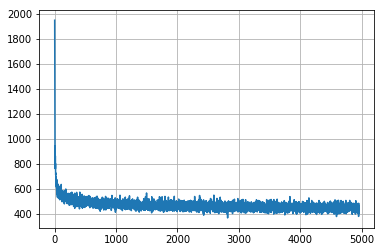

In [90]:
plt.plot(history)
plt.grid()

## Применение RNN

Только что у нас обучилась модель, которая предсказывает вероятности следующего символа.
Теперь давайте применим её к строке из одного пробела. Получим вероятности первой буквы имени. После чего:
* $x_t \sim P(x_t | h_t)$ — выберем букву пропорционально вероятностям.
* $h_{t+1} = \text{get_h_next}(h_t, x_t)$ — присоединим букву к имени и прогоним через RNN


Для начала инициализируем необходимые переменные:

In [91]:
x_t = tf.placeholder('int32', (1,))
h_t = tf.Variable(np.zeros([1, rnn_size], 'float32'))

next_h, next_probs = rnn_one_step(x_t, h_t)

И будем использовать функцию ниже для генерации новых имен!

In [92]:
def generate_sample(seed_phrase=' ', max_length=MAX_LENGTH):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    sess.run(tf.variables_initializer([h_t]))
    
    #feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         sess.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    #start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs, _ = sess.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence])

Посмотрим, что же придумала наша модель:

In [93]:
for _ in range(10):
    print(generate_sample())

 March          
 Pivelle        
 Rusy           
 Karie          
 Esmet          
 Hansi          
 Harmott        
 Farida         
 Shamie         
 Hulla          


In [95]:
for _ in range(10):
    print(generate_sample(' Trump'))

 Trumpetta      
 Trumpy         
 Trumpi         
 Trumpe         
 Trumpi         
 Trumpiew       
 Trumpie        
 Trumpie        
 Trumpar        
 Trumpie        


Ну, получилось прикольно. Никаких комментариев не писала, вроде и так понятно, что нужно делать.

### Что теперь?

Если вам наскучит решать повседневные задачи или вам нужны новые идеи, вы теперь всегда можете воспользоваться RNN чтобы сгенерировать что-то новое. Вот несколько задач, от которых можно отталкиваться:
* названия статей по глубинному обучению;
* названия карт Magic The Gathering;
* [имена покемонов](https://github.com/cervoise/pentest-scripts/blob/master/password-cracking/wordlists/pokemon-list-en.txt);
* clickbait заголовки;
* молекулы в формате [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system);
* ваша фантазия, с ограничениями которой вы уже должны были понять как бороться.

Если возьмётесь за эту задачу, то вот несколько полезных советов:
* Сейчас модель обучается на коротких строчках. Если у вас роман, его придётся порезать на кускочки.
* Если длина строк сильно варьируется, можно поставить параметр MAX_LENGTH так, чтобы он покрывал 90%. Это обычно дает ускорение примерно в 2 раза.
* Для более сложных задач требуется больше нейронов (rnn_size). Кроме того, можно экспериментировать и со составляющими сети (см. ниже).

### Ещё почитать

* [Подборка советов](https://danijar.com/tips-for-training-recurrent-neural-networks/) по обучению RNN. Чуть более полезная, чем обычно.
* Отличный блог-пост от Andrej Karpathy про языковые модели на rnn, их применение и визуализацию — [Unreasonable Effectiveness of RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).
* Большой список статей, постов, реализаций и прочих полезностей по RNN - [awesome rnn](https://github.com/kjw0612/awesome-rnn).
* [Зоопарк](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn) готовых рекуррентных ячеек (LSTM, GRU) в TF. И ещё одна реализация [в карасе](https://keras.io/layers/recurrent/).
* Сейчас мы настраиваем количество итераций заранее. Если вы хотите определять их динамически, милости просим в [tf.while_loop](https://www.tensorflow.org/api_docs/python/tf/while_loop) или [tf.scan](https://www.tensorflow.org/api_docs/python/tf/scan).
* А ещё рекуррентные сети можно аугментировать механизмом внимания или долговременной памятью. Вот тут есть [хорошая статья](https://distill.pub/2016/augmented-rnns/).